In [ ]:
!pip install split-folders
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 677.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
import os
import tensorflow as tf
import shutil
import splitfolders
import numpy as np
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, UnidentifiedImageError
from importlib.metadata import files
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
print("TensorFlow Version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.18.0
Built with CUDA: True
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Preparation

### Data Loading

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saftaflow","key":"9559267a3600b1eff08149735c32abab"}'}

In [ ]:
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d zuhairnashif/image25

Dataset URL: https://www.kaggle.com/datasets/zuhairnashif/image25
License(s): unknown
 95% 665M/701M [00:03<00:00, 131MB/s] 
100% 701M/701M [00:03<00:00, 206MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('image25.zip', 'r') as zip_ref:
    zip_ref.extractall('images')

### Data Preprocessing

#### Split Dataset

In [ ]:
splitfolders.ratio("images/dataset baru",
                   output="images/output",
                   seed=1337,
                   ratio=(.8, .1, .1))  # train:val:test

Copying files: 7142 files [00:03, 2039.27 files/s]


In [ ]:
IMAGE_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')

def count_image_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.lower().endswith(IMAGE_EXTENSIONS):
                count += 1
    return count

train_dir = "images/output/train"
val_dir = "images/output/val"
test_dir = "images/output/test"

train_count = count_image_files(train_dir)
val_count = count_image_files(val_dir)
test_count = count_image_files(test_dir)

print(f"Jumlah file gambar di folder train (termasuk subfolder): {train_count}")
print(f"Jumlah file gambar di folder val (termasuk subfolder): {val_count}")
print(f"Jumlah file gambar di folder test (termasuk subfolder): {test_count}")

Jumlah file gambar di folder train (termasuk subfolder): 5700
Jumlah file gambar di folder val (termasuk subfolder): 709
Jumlah file gambar di folder test (termasuk subfolder): 723


#### Data Augmentation

In [ ]:
base_dir = "images/output"

# Data generator untuk training (dengan augmentasi)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Data generator untuk validasi & test (tanpa augmentasi)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    base_dir + '/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    base_dir + '/val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    base_dir + '/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 5700 images belonging to 25 classes.
Found 709 images belonging to 25 classes.
Found 723 images belonging to 25 classes.


In [ ]:
def remove_invalid_images(directory):
    num_removed = 0
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if not os.path.isdir(folder_path):
            continue
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # cek validitas gambar
            except (UnidentifiedImageError, IOError, SyntaxError):
                print(f"Removing invalid file: {file_path}")
                os.remove(file_path)
                num_removed += 1
    print(f"Total invalid images removed: {num_removed}")

remove_invalid_images("images/output/train")
remove_invalid_images("images/output/val")
remove_invalid_images("images/output/test")

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)


Removing invalid file: images/output/train/udang/fresh-raw-shrimp-seafood-ingredient-cooking_99974-925.avif
Removing invalid file: images/output/train/udang/feature.avif
Removing invalid file: images/output/train/buncis/green-beans-closeup-view_118047-14376.avif
Removing invalid file: images/output/train/buncis/green-beans-closeup-view_118047-13824.avif
Removing invalid file: images/output/train/buncis/pilha-de-feijao-verde-em-uma-banca-de-mercado_633872-1138.avif
Removing invalid file: images/output/train/jamur tiram/jamur-tiram-oyster-mushrooms_685424-11.avif
Removing invalid file: images/output/train/telur/TB2C0pXnDlYBeNjSszcXXbwhFXa_!!668081813.avif
Total invalid images removed: 7
Total invalid images removed: 0
Removing invalid file: images/output/test/buncis/green-bean-top-view_957803-2701.avif
Removing invalid file: images/output/test/jamur enoki/flammulina-filiformis-is-species-agaric-family-physalacriaceae-enokitake-mushroom-enoki_717054-1042.avif
Total invalid images removed:

#### Train and test generator

In [ ]:
# Data generator untuk train (dengan augmentasi)
train_datagen = ImageDataGenerator(rescale=1./255)

# Data generator untuk test & val (tanpa augmentasi)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator untuk training
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Generator untuk validasi
validation_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Generator untuk testing
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

print("\nData generators created successfully.")


Found 5700 images belonging to 25 classes.
Found 709 images belonging to 25 classes.
Found 723 images belonging to 25 classes.

Data generators created successfully.


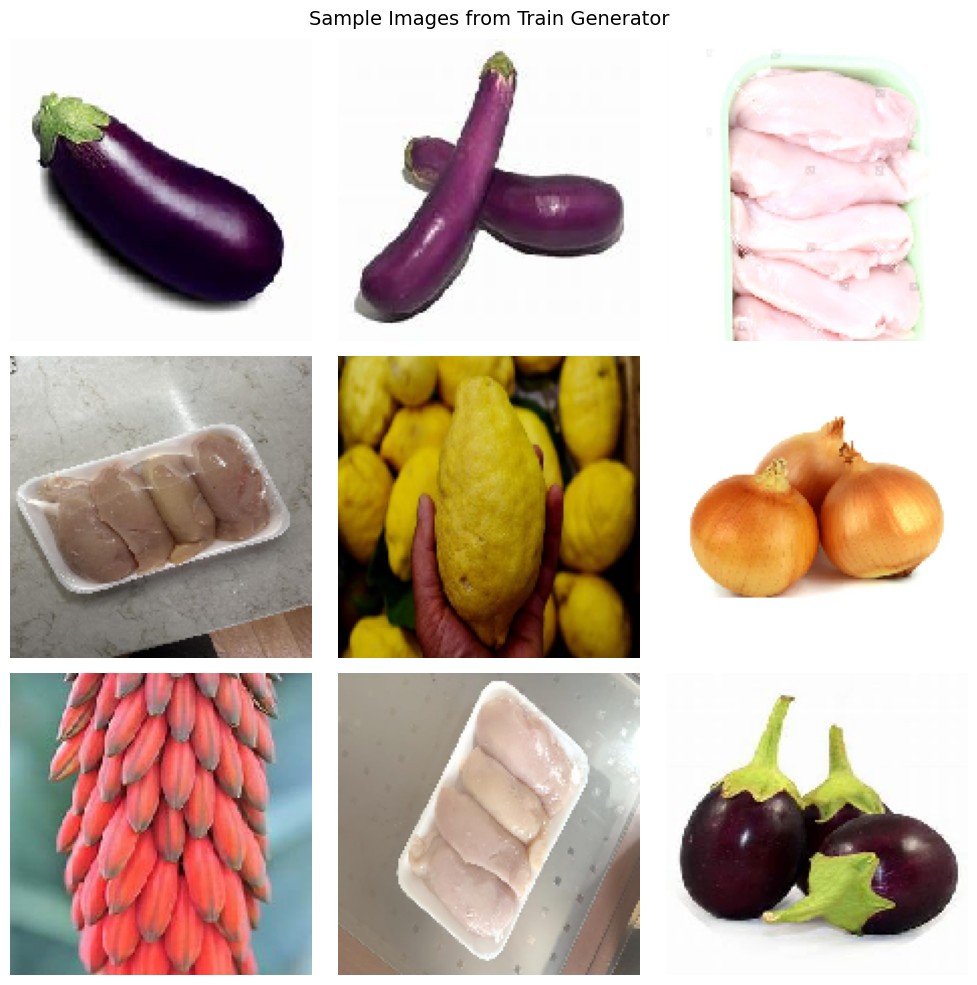

In [ ]:
# Ambil batch pertama dari train_generator
sample_images, sample_labels = next(train_generator)

# Skala balik ke 0–255 agar bisa divisualisasi dengan baik
sample_images = sample_images * 255

# Visualisasi 9 gambar pertama
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = sample_images[i].astype("uint8")
    plt.imshow(img)
    plt.axis("off")

plt.suptitle("Sample Images from Train Generator", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
def print_images_resolution(directory):
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if not os.path.isdir(subdir_path):
            continue

        image_files = os.listdir(subdir_path)
        num_images = 0
        unique_sizes = set()

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            try:
                with Image.open(img_path) as img:
                    unique_sizes.add(img.size)
                    num_images += 1
            except Exception as e:
                print(f"Could not open {img_file}: {e}")

        print(f"{subdir}: {num_images} images")
        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")
        total_images += num_images

    print(f"\nTotal images in '{directory}': {total_images}")

train_dir = os.path.join(base_dir, 'train')
print_images_resolution(train_dir)

lemon: 874 images
- (268, 201)
- (1700, 1249)
- (178, 164)
- (219, 165)
- (116, 180)
- (261, 180)
- (206, 244)
- (495, 612)
- (177, 284)
- (238, 300)
- (186, 271)
- (203, 202)
- (223, 180)
- (276, 183)
- (150, 196)
- (300, 400)
- (264, 199)
- (227, 168)
- (612, 406)
- (200, 300)
- (211, 300)
- (280, 180)
- (222, 300)
- (720, 1080)
- (257, 196)
- (242, 162)
- (408, 612)
- (279, 300)
- (147, 162)
- (242, 180)
- (253, 180)
- (234, 176)
- (149, 199)
- (1533, 1252)
- (306, 164)
- (735, 1101)
- (241, 300)
- (264, 176)
- (2304, 3456)
- (192, 300)
- (123, 191)
- (272, 180)
- (115, 196)
- (177, 180)
- (250, 259)
- (250, 268)
- (222, 169)
- (201, 250)
- (224, 224)
- (432, 402)
- (276, 182)
- (264, 180)
- (162, 160)
- (287, 191)
- (279, 196)
- (225, 225)
- (226, 199)
- (176, 180)
- (187, 180)
- (241, 160)
- (430, 612)
- (1200, 902)
- (198, 198)
- (207, 176)
- (282, 179)
- (274, 184)
- (199, 199)
- (138, 180)
- (255, 198)
- (2037, 1669)
- (1024, 681)
- (1200, 785)
- (298, 168)
- (276, 168)
- (215,

## Modelling

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Freezing the base model

# Model baru
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(2, activation='softmax')  # 2 kelas: kucing dan anjing
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,637,826 (93.99 MB)

 Trainable params: 1,050,114 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Model base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Freezing the base model

# Model baru
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(2, activation='softmax')  # 2 kelas: kucing dan anjing
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


<ipython-input-17-74c281208ee6>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,914,882 (11.12 MB)

 Trainable params: 656,898 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)